# От Атлантики до Авиньона: диалог эпох (версия с LoRA)

> LoRA (Low-Rank Adaptation) - это техника дообучения, которая добавляет маленькие адаптеры к модели вместо изменения всех весов, что экономит память и ускоряет обучение

## Идея


Выбор данных для проекта
Из всего датасета мы отобрали изображения работ только двух художников:

* **Уинслоу Гомер (Winslow Homer)**: 14 изображений. Американский художник-реалист XIX века, известный морскими пейзажами, сценами повседневной жизни и изображениями природы. Его стиль характеризуется реалистичным изображением света, цвета и динамики (например, волны, ветер, люди в естественной среде).

* **Пабло Пикассо (Pablo Picasso)**: 17 изображений. Испанский художник XX века, один из основоположников кубизма, с абстрактными формами, геометрическими фигурами и экспериментами с перспективо

Идея проекта — создать "диалог эпох" через генеративное искусство: обучить Stable Diffusion на стилях двух контрастных художников, чтобы сгенерировать серию изображений, иллюстрирующих эволюцию искусства от классического реализма к модернистскому кубизму.


# Данные

Для обучения моделей Stable Diffusion мы использовали данные из National Gallery of Art Open Data Program — открытого репозитория, предоставляемого Национальной галереей искусства США (National Gallery of Art, NGA). Этот датасет содержит метаданные о более чем 130,000 произведениях искусства из коллекции галереи, включая информацию об авторах, названиях работ, датах создания, материалах и ссылках на изображения. Данные доступны в формате CSV и обновляются ежедневно.

Репозиторий: [github.com/NationalGalleryOfArt/opendata](https://github.com/NationalGalleryOfArt/opendata)

Страница с политикой открытого доступа к изображениям: [nga.gov/artworks/free-images-and-open-access](https://www.nga.gov/artworks/free-images-and-open-access)



#### Дисклеймер о легальности использования

Данные и изображения из этого источника выпущены под лицензией Creative Commons Zero (CC0 1.0), что означает полное отречение от авторских прав и смежных прав. Это позволяет свободно использовать, модифицировать, распространять и применять данные в любых целях, включая коммерческие, без необходимости указания авторства или получения разрешения.

> Мы собрали датасет вручную из открытого источника, отобрав качественные изображения (без шумов, высокое разрешение), чтобы обеспечить хорошую обучаемость.

In [ ]:
!wget https://raw.githubusercontent.com/ekaterinagolubeva/hse-dl-course/refs/heads/main/project/NGA_Dataset.zip -O NGA_Dataset.zip

!unzip -q NGA_Dataset.zip -d .

!mv NGA_Dataset NGA_Dataset_lora

--2025-10-15 04:29:50--  https://raw.githubusercontent.com/ekaterinagolubeva/hse-dl-course/refs/heads/main/project/NGA_Dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53090199 (51M) [application/zip]
Saving to: ‘NGA_Dataset.zip’

NGA_Dataset.zip     100%[===================>]  50.63M   201MB/s    in 0.3s    

2025-10-15 04:29:53 (201 MB/s) - ‘NGA_Dataset.zip’ saved [53090199/53090199]



In [2]:
!pip install -q transformers==4.49 diffusers==0.32.2 accelerate datasets torch torchvision pillow xformers peft bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 147.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 124.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.5 MB/s eta 0:00:00


## 2. Подготовка данных

Загружаем и анализируем датасет с картинами Гомера и Пикассо


In [ ]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

description_df = pd.read_csv("NGA_Dataset_lora/description.csv")

print(f"Всего изображений: {len(description_df)}")
print("\nРаспределение по художникам:")
print(description_df['artist'].value_counts())

Всего изображений: 31

Распределение по художникам:
artist
Picasso, Pablo    17
Homer, Winslow    14
Name: count, dtype: int64


In [5]:
description_df[['filename', 'artist', 'title', 'date']].head(3)

filename          artist  \
0  1155a052-5f8d-4168-80dc-750ca9c5e497.jpg  Homer, Winslow   
1  1f56dea6-546c-4576-9596-0bf20f1c60e5.jpg  Homer, Winslow   
2  26833f2a-be4f-43cc-9216-b226c37557a3.jpg  Picasso, Pablo   

                      title     date  
0          Home, Sweet Home  c. 1863  
1  Sketch of a Cottage Yard  c. 1876  
2            Classical Head     1922

In [ ]:
homer_df = description_df[description_df['artist'].str.contains('Homer', case=False, na=False)]
picasso_df = description_df[description_df['artist'].str.contains('Picasso', case=False, na=False)]

os.makedirs("dataset_homer_lora", exist_ok=True)
os.makedirs("dataset_picasso_lora", exist_ok=True)

for filename in homer_df['filename']:
    src = os.path.join("NGA_Dataset_lora", filename)
    dst = os.path.join("dataset_homer_lora", filename)
    if os.path.exists(src) and not os.path.exists(dst):
        import shutil
        shutil.copy(src, dst)

for filename in picasso_df['filename']:
    src = os.path.join("NGA_Dataset_lora", filename)
    dst = os.path.join("dataset_picasso_lora", filename)
    if os.path.exists(src) and not os.path.exists(dst):
        import shutil
        shutil.copy(src, dst)

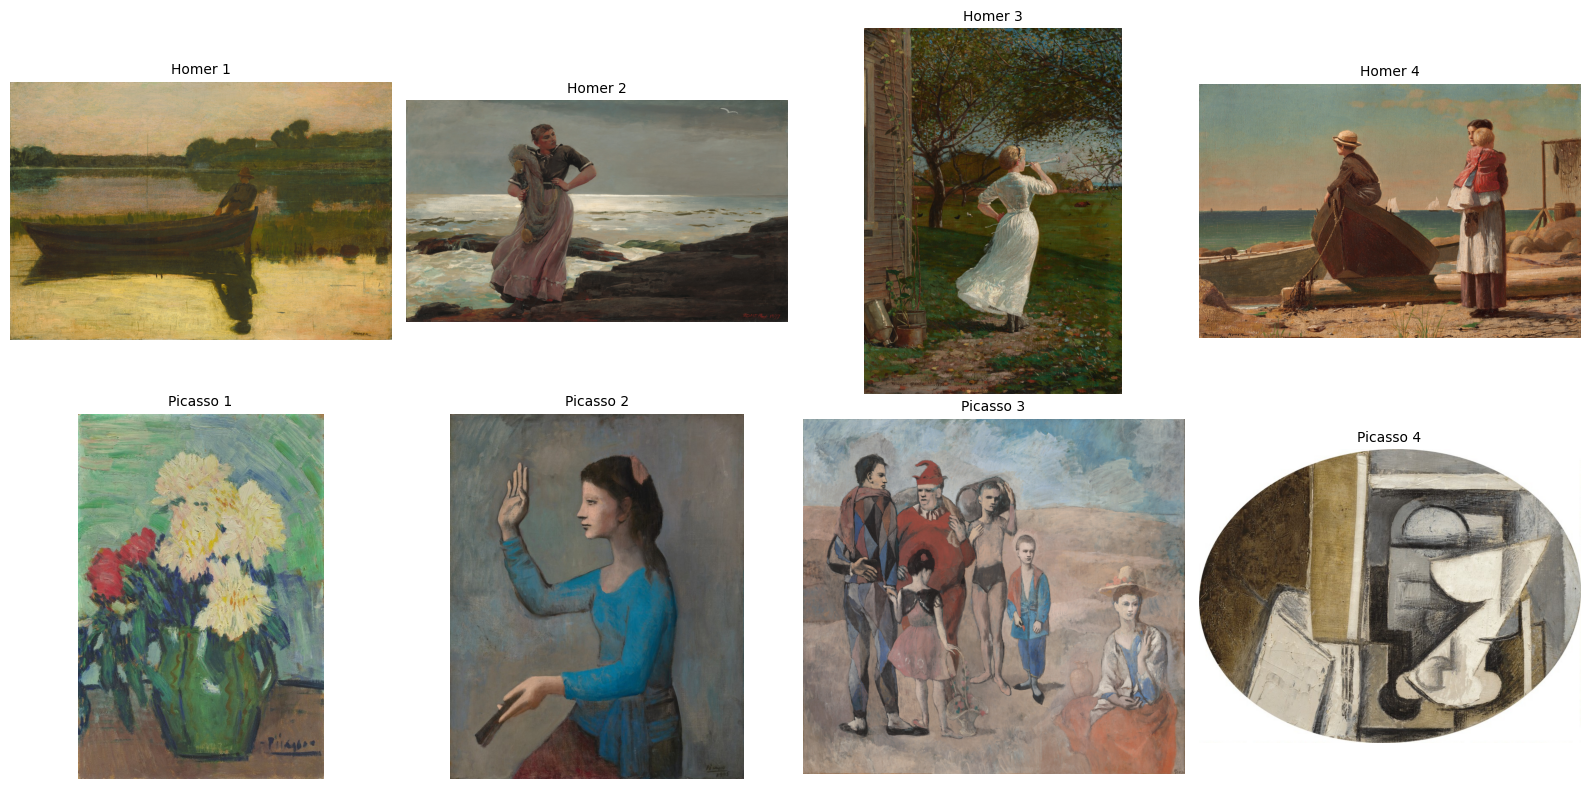

In [ ]:
import os

if not os.path.exists('./assets'):
    os.makedirs("./assets")

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

homer_files = os.listdir('dataset_homer_lora')[:4]
for idx, filename in enumerate(homer_files):
    img = Image.open(os.path.join('dataset_homer_lora', filename))
    axes[0, idx].imshow(img)
    axes[0, idx].set_title(f'Homer {idx+1}', fontsize=10)
    axes[0, idx].axis('off')

picasso_files = os.listdir('dataset_picasso_lora')[:4]
for idx, filename in enumerate(picasso_files):
    img = Image.open(os.path.join('dataset_picasso_lora', filename))
    axes[1, idx].imshow(img)
    axes[1, idx].set_title(f'Picasso {idx+1}', fontsize=10)
    axes[1, idx].axis('off')

plt.tight_layout()
plt.savefig('assets/dataset_examples_lora.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Подготовка модели и обучение с LoRA

Для обучения использовали технику LoRA (Low-Rank Adaptation) для экономии ресурсов и предотвращения переобучения на небольшом датасете. Без него постоянно было CUDA out of memory

Создаём класс датасета и настраиваем LoRA для обучения

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers.optimization import get_scheduler
from tqdm.auto import tqdm

class ArtistDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir

        self.image_paths = [os.path.join(image_dir, fname)
                           for fname in os.listdir(image_dir)
                           if fname.endswith(('.jpg', '.png', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        return {"pixel_values": image}

In [ ]:
import gc
import torch
import os
from typing import Dict, Optional, Tuple
from accelerate import Accelerator
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers.optimization import get_scheduler
from tqdm.auto import tqdm
from peft import LoraConfig, get_peft_model

def cleanup_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

def load_sd_components_lora(
    model_id: str = "runwayml/stable-diffusion-v1-5",
    device: str = "cuda",
    dtype: torch.dtype = torch.float16,
    load_safety_checker: bool = False
) -> Dict:
    print(f"Загрузка компонентов из {model_id}...")

    tokenizer = CLIPTokenizer.from_pretrained(
        model_id,
        subfolder="tokenizer"
    )

    text_encoder = CLIPTextModel.from_pretrained(
        model_id,
        subfolder="text_encoder",
        torch_dtype=dtype
    ).to(device)

    unet = UNet2DConditionModel.from_pretrained(
        model_id,
        subfolder="unet",
        torch_dtype=dtype
    ).to(device)

    vae = StableDiffusionPipeline.from_pretrained(
        model_id,
        torch_dtype=dtype
    ).vae.to(device)

    noise_scheduler = DDPMScheduler.from_pretrained(
        model_id,
        subfolder="scheduler"
    )

    components = {
        "tokenizer": tokenizer,
        "text_encoder": text_encoder,
        "unet": unet,
        "vae": vae,
        "noise_scheduler": noise_scheduler
    }

    if load_safety_checker:
        from transformers import AutoFeatureExtractor
        safety_checker = StableDiffusionPipeline.from_pretrained(
            model_id,
            torch_dtype=dtype
        ).safety_checker
        feature_extractor = AutoFeatureExtractor.from_pretrained(model_id)

        components["safety_checker"] = safety_checker
        components["feature_extractor"] = feature_extractor

    print("✓ Компоненты загружены")
    return components

def apply_model_optimizations(
    components: Dict,
    enable_gradient_checkpointing: bool = True,
    enable_xformers: bool = True,
    enable_cpu_offload: bool = False,
    freeze_vae: bool = True,
    freeze_text_encoder: bool = True
) -> Dict:
    unet = components["unet"]
    text_encoder = components["text_encoder"]
    vae = components["vae"]

    if enable_gradient_checkpointing:
        unet.enable_gradient_checkpointing()
        if hasattr(text_encoder, 'gradient_checkpointing_enable'):
            text_encoder.gradient_checkpointing_enable()
        print("Gradient checkpointing включен")

    if enable_xformers:
        try:
            unet.enable_xformers_memory_efficient_attention()
            print("xFormers включен для эффективного внимания")
        except Exception as e:
            print(f"xFormers недоступен: {e}")

            try:
                from diffusers.models.attention_processor import AttnProcessor2_0
                unet.set_attn_processor(AttnProcessor2_0())
                print("Использован AttnProcessor2_0 вместо xFormers")
            except:
                print("Используется стандартное внимание")

    if enable_cpu_offload:
        unet.enable_sequential_cpu_offload()
        print("CPU offload включен")

    if freeze_vae:
        vae.requires_grad_(False)
        vae.eval()
        print("VAE заморожен")

    if freeze_text_encoder:
        text_encoder.requires_grad_(False)
        text_encoder.eval()
        print("Text encoder заморожен")

    return components

def apply_lora_to_unet(
    unet: UNet2DConditionModel,
    rank: int = 4,
    alpha: int = 8,
    target_modules: list = None
) -> UNet2DConditionModel:

    if target_modules is None:
        target_modules = [
            "to_q", "to_k", "to_v", "to_out.0",
            "proj_in", "proj_out",
            "conv1", "conv2"
        ]

    lora_config = LoraConfig(
        r=rank,
        lora_alpha=alpha,
        target_modules=target_modules,
        lora_dropout=0.1,
        bias="none"
    )

    unet_lora = get_peft_model(unet, lora_config)

    print(f"LoRA применена к UNet (rank={rank}, alpha={alpha})")
    print(f"  Целевые модули: {target_modules}")

    trainable_params = sum(p.numel() for p in unet_lora.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in unet_lora.parameters())
    print(f"  Обучаемых параметров: {trainable_params:,} из {total_params:,} ({trainable_params/total_params*100:.2f}%)")

    return unet_lora

def create_and_save_lora_pipeline(
    components: Dict,
    output_dir: str,
    enable_xformers: bool = True
) -> StableDiffusionPipeline:

    pipeline = StableDiffusionPipeline(
        vae=components["vae"],
        text_encoder=components["text_encoder"],
        tokenizer=components["tokenizer"],
        unet=components["unet"],
        scheduler=components["noise_scheduler"],
        safety_checker=components.get("safety_checker", None),
        feature_extractor=components.get("feature_extractor", None),
        requires_safety_checker=False,
    )

    if enable_xformers:
        try:
            pipeline.enable_xformers_memory_efficient_attention()
        except:
            pass

    os.makedirs(output_dir, exist_ok=True)

    components["unet"].save_pretrained(os.path.join(output_dir, "unet_lora"))

    print(f"LoRA адаптеры сохранены в {output_dir}")

    return pipeline

def setup_training(
    components: Dict,
    learning_rate: float = 1e-4,
    max_train_steps: int = 300,
    gradient_accumulation_steps: int = 1,
    mixed_precision: str = "fp16",
    warmup_steps: int = 0
) -> Tuple[Accelerator, torch.optim.Optimizer, object]:

    accelerator = Accelerator(
        mixed_precision=mixed_precision,
        gradient_accumulation_steps=gradient_accumulation_steps
    )

    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, components["unet"].parameters()),
        lr=learning_rate,
        betas=(0.9, 0.999),
        weight_decay=0.01,
        eps=1e-08
    )

    lr_scheduler = get_scheduler(
        "constant",
        optimizer=optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=max_train_steps * gradient_accumulation_steps,
    )

    return accelerator, optimizer, lr_scheduler

In [ ]:
def train_model_with_lora(
    dataset_dir,
    output_dir,
    artist_name,
    resolution=512,
    batch_size=4,
    learning_rate=1e-4,
    num_epochs=5,
    max_train_steps=500,
    use_xformers=True,
    mixed_precision="fp16",
    gradient_checkpointing=True,
    model_id="runwayml/stable-diffusion-v1-5",
    lora_rank=16,
    lora_alpha=32
):

    print(f"="*60)
    print(f"Начало обучения модели с LoRA для стиля {artist_name}")
    print(f"="*60)

    gradient_accumulation_steps = 1
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dtype = torch.float16 if mixed_precision == "fp16" else torch.float32

    transform = transforms.Compose([
        transforms.Resize((resolution, resolution)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ])

    dataset = ArtistDataset(dataset_dir, transform=transform)
    print(f"Размер датасета: {len(dataset)} изображений")
    print(f"Разрешение: {resolution}x{resolution}")
    print(f"Mixed precision: {mixed_precision}")
    print(f"Gradient checkpointing: {gradient_checkpointing}")
    print(f"LoRA rank: {lora_rank}, alpha: {lora_alpha}")

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=2
    )

    components = load_sd_components_lora(
        model_id=model_id,
        device=device,
        dtype=dtype,
        load_safety_checker=False
    )

    components = apply_model_optimizations(
        components,
        enable_gradient_checkpointing=gradient_checkpointing,
        enable_xformers=use_xformers,
        enable_cpu_offload=False,
        freeze_vae=True,
        freeze_text_encoder=True
    )

    components["unet"] = apply_lora_to_unet(
        components["unet"],
        rank=lora_rank,
        alpha=lora_alpha
    )

    accelerator, optimizer, lr_scheduler = setup_training(
        components,
        learning_rate=learning_rate,
        max_train_steps=max_train_steps,
        gradient_accumulation_steps=gradient_accumulation_steps,
        mixed_precision=mixed_precision,
        warmup_steps=0
    )

    unet = components["unet"]
    vae = components["vae"]
    text_encoder = components["text_encoder"]
    tokenizer = components["tokenizer"]
    noise_scheduler = components["noise_scheduler"]

    unet, optimizer, dataloader, lr_scheduler = accelerator.prepare(
        unet, optimizer, dataloader, lr_scheduler
    )

    global_step = 0

    for epoch in tqdm(range(num_epochs), desc='Эпоха'):

        for step, batch in enumerate(dataloader):
            if global_step >= max_train_steps:
                break

            with torch.no_grad():
                pixel_values = batch["pixel_values"].to(accelerator.device, dtype=vae.dtype)
                latents = vae.encode(pixel_values).latent_dist.sample()
                latents = latents * 0.18215

            noise = torch.randn_like(latents)
            bsz = latents.shape[0]

            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device)
            timesteps = timesteps.long()

            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            with torch.no_grad():
                dummy_prompt = [""] * bsz
                input_ids = tokenizer(
                    dummy_prompt,
                    padding="max_length",
                    truncation=True,
                    max_length=tokenizer.model_max_length,
                    return_tensors="pt",
                ).input_ids.to(accelerator.device)
                encoder_hidden_states = text_encoder(input_ids)[0]

            with accelerator.accumulate(unet):
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
                
                loss = torch.nn.functional.mse_loss(noise_pred.float(), noise.float(), reduction="mean")

                accelerator.backward(loss)

                if accelerator.sync_gradients:

                    accelerator.clip_grad_norm_(unet.parameters(), 1.0)

                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            if accelerator.sync_gradients:
                global_step += 1

                avg_loss = accelerator.gather(loss.repeat(batch_size)).mean()

                if global_step % 100 == 0:
                    if accelerator.is_main_process:
                        checkpoint_dir = f"{output_dir}-checkpoint-{global_step}"
                        os.makedirs(checkpoint_dir, exist_ok=True)
                        unwrapped_unet = accelerator.unwrap_model(unet)
                        unwrapped_unet.save_pretrained(os.path.join(checkpoint_dir, "unet_lora"))
                        print(f"\nКонтрольная точка сохранена: {checkpoint_dir}")

        cleanup_memory()

    accelerator.wait_for_everyone()

    if accelerator.is_main_process:

        unwrapped_unet = accelerator.unwrap_model(unet)
        components["unet"] = unwrapped_unet

        pipeline = create_and_save_lora_pipeline(
            components,
            output_dir,
            enable_xformers=use_xformers
        )

        cleanup_memory()

        return pipeline

    return None

In [ ]:
def optimize_for_memory_limit_lora(memory_limit_gb=15):
    if memory_limit_gb >= 12:
        return {
            "resolution": 512,
            "batch_size": 4,
            "lora_rank": 8,
            "lora_alpha": 16,
            "description": "Стандартные настройки LoRA для GPU 12-15GB"
        }
    else:
        return {
            "resolution": 256,
            "batch_size": 2,
            "lora_rank": 4,
            "lora_alpha": 8,
            "description": "Минимальные настройки LoRA для GPU < 8GB"
        }

if torch.cuda.is_available():

    total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3

    recommendations = optimize_for_memory_limit_lora(total_memory)

    print(f"\n Рекомендуемые параметры LoRA для вашего GPU ({total_memory:.1f} GB):")
    print(f"  {recommendations['description']}")
    print(f"  - Разрешение: {recommendations['resolution']}x{recommendations['resolution']}")
    print(f"  - Batch size: {recommendations['batch_size']}")
    print(f"  - LoRA rank: {recommendations['lora_rank']}")
    print(f"  - LoRA alpha: {recommendations['lora_alpha']}")


 Рекомендуемые параметры LoRA для вашего GPU (14.7 GB):
  Стандартные настройки LoRA для GPU 12-15GB
  - Разрешение: 512x512
  - Batch size: 4
  - LoRA rank: 8
  - LoRA alpha: 16


In [ ]:
if torch.cuda.is_available():

    total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    params = optimize_for_memory_limit_lora(total_memory)

    sdx_pipeline = train_model_with_lora(
        dataset_dir="./NGA_Dataset_lora",
        output_dir="./output_lora",
        artist_name="mixed_picasso_homer_lora",
        resolution=params["resolution"],
        batch_size=params["batch_size"],
        learning_rate=1e-4,
        num_epochs=64,
        max_train_steps=128,
        use_xformers=True,
        mixed_precision="fp16",
        gradient_checkpointing=True,
        lora_rank=params["lora_rank"],
        lora_alpha=params["lora_alpha"]
    )

    cleanup_memory()

else:
    raise RuntimeError(
        "GPU не обнаружен. Без него лучше не обучать :/"
    )

Начало обучения модели с LoRA для стиля mixed_picasso_homer_lora
Размер датасета: 31 изображений
Разрешение: 512x512
Mixed precision: fp16
Gradient checkpointing: True
LoRA rank: 8, alpha: 16
Загрузка компонентов из runwayml/stable-diffusion-v1-5...


unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

✓ Компоненты загружены
Gradient checkpointing включен
xFormers включен для эффективного внимания
VAE заморожен
Text encoder заморожен
LoRA применена к UNet (rank=8, alpha=16)
  Целевые модули: ['to_q', 'to_k', 'to_v', 'to_out.0', 'proj_in', 'proj_out', 'conv1', 'conv2']
  Обучаемых параметров: 5,910,528 из 865,431,492 (0.68%)


Эпоха:   0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)



Контрольная точка сохранена: ./output_lora-checkpoint-100
LoRA адаптеры сохранены в ./output_lora


## 4. Генерация изображений с обученными LoRA моделями

Функции для загрузки LoRA адаптеров и генерации изображений


In [ ]:
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from peft import PeftModel
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt

def load_lora_for_inference(
    base_model_id="runwayml/stable-diffusion-v1-5",
    lora_model_path="./output_lora/unet_lora",
    device="cuda",
    dtype=torch.float16
):
    print(f"Загрузка базовой модели {base_model_id}...")

    pipe = StableDiffusionPipeline.from_pretrained(
        base_model_id,
        torch_dtype=dtype,
        safety_checker=None,
        requires_safety_checker=False
    ).to(device)

    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

    try:
        pipe.enable_xformers_memory_efficient_attention()
    except:
        try:
            from diffusers.models.attention_processor import AttnProcessor2_0
            pipe.unet.set_attn_processor(AttnProcessor2_0())
        except:
            print("!!! Используется standart attention")

    if not os.path.exists(lora_model_path):
        print(f"!!! LoRA модель не найдена по пути {lora_model_path}")
        print("Возвращаем базовую модель без LoRA")
        return pipe

    print(f"Загрузка LoRA адаптеров из {lora_model_path}...")

    pipe.unet = PeftModel.from_pretrained(
        pipe.unet,
        lora_model_path,
        adapter_name="default"
    )

    return pipe

def generate_images(
    pipe,
    prompts,
    negative_prompt="ugly, blurry, pixelated, deformed, low quality",
    num_images=1,
    guidance_scale=7.5,
    num_inference_steps=30,
    seed=None,
    width=512,
    height=512
):

    if isinstance(prompts, str):
        prompts = [prompts]

    if seed is not None:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

    all_images = []

    for prompt in prompts:
        print(f"Генерация для промпта: '{prompt}'")

        result = pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            num_images_per_prompt=num_images,
            guidance_scale=guidance_scale,
            num_inference_steps=num_inference_steps,
            width=width,
            height=height
        )

        all_images.extend(result.images)

    return all_images

def display_grid(images, rows=2, cols=2, figsize=(10, 10), titles=None):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, img in enumerate(images[:rows*cols]):
        axes[i].imshow(img)
        axes[i].axis('off')
        if titles and i < len(titles):
            axes[i].set_title(titles[i])

    plt.tight_layout()
    plt.show()

In [20]:
sdx_pipe = load_lora_for_inference(
    base_model_id="runwayml/stable-diffusion-v1-5",
    lora_model_path="./output_lora/unet_lora",
    device="cuda",
    dtype=torch.float16
)

Загрузка базовой модели runwayml/stable-diffusion-v1-5...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Загрузка LoRA адаптеров из ./output_lora/unet_lora...


In [ ]:
core_prompts = [
    "a coastal landscape with boats and fishermen",
    "a serene countryside scene with people",
    "a dramatic seascape with stormy waves",
    "a portrait of woman",
    "a portrait of man",
]

prompts = core_prompts + [item + " with cubistic aesthetic" for item in core_prompts]

sdx_images = generate_images(
    sdx_pipe,
    prompts=prompts,
    num_images=1,
    guidance_scale=7.5,
    num_inference_steps=30,
    seed=42,
    width=512,
    height=512
)

Генерация для промпта: 'a coastal landscape with boats and fishermen'


  0%|          | 0/30 [00:00<?, ?it/s]

Генерация для промпта: 'a serene countryside scene with people'


  0%|          | 0/30 [00:00<?, ?it/s]

Генерация для промпта: 'a dramatic seascape with stormy waves'


  0%|          | 0/30 [00:00<?, ?it/s]

Генерация для промпта: 'a portrait of woman'


  0%|          | 0/30 [00:00<?, ?it/s]

Генерация для промпта: 'a portrait of man'


  0%|          | 0/30 [00:00<?, ?it/s]

Генерация для промпта: 'a coastal landscape with boats and fishermen with cubistic aesthetic'


  0%|          | 0/30 [00:00<?, ?it/s]

Генерация для промпта: 'a serene countryside scene with people with cubistic aesthetic'


  0%|          | 0/30 [00:00<?, ?it/s]

Генерация для промпта: 'a dramatic seascape with stormy waves with cubistic aesthetic'


  0%|          | 0/30 [00:00<?, ?it/s]

Генерация для промпта: 'a portrait of woman with cubistic aesthetic'


  0%|          | 0/30 [00:00<?, ?it/s]

Генерация для промпта: 'a portrait of man with cubistic aesthetic'


  0%|          | 0/30 [00:00<?, ?it/s]

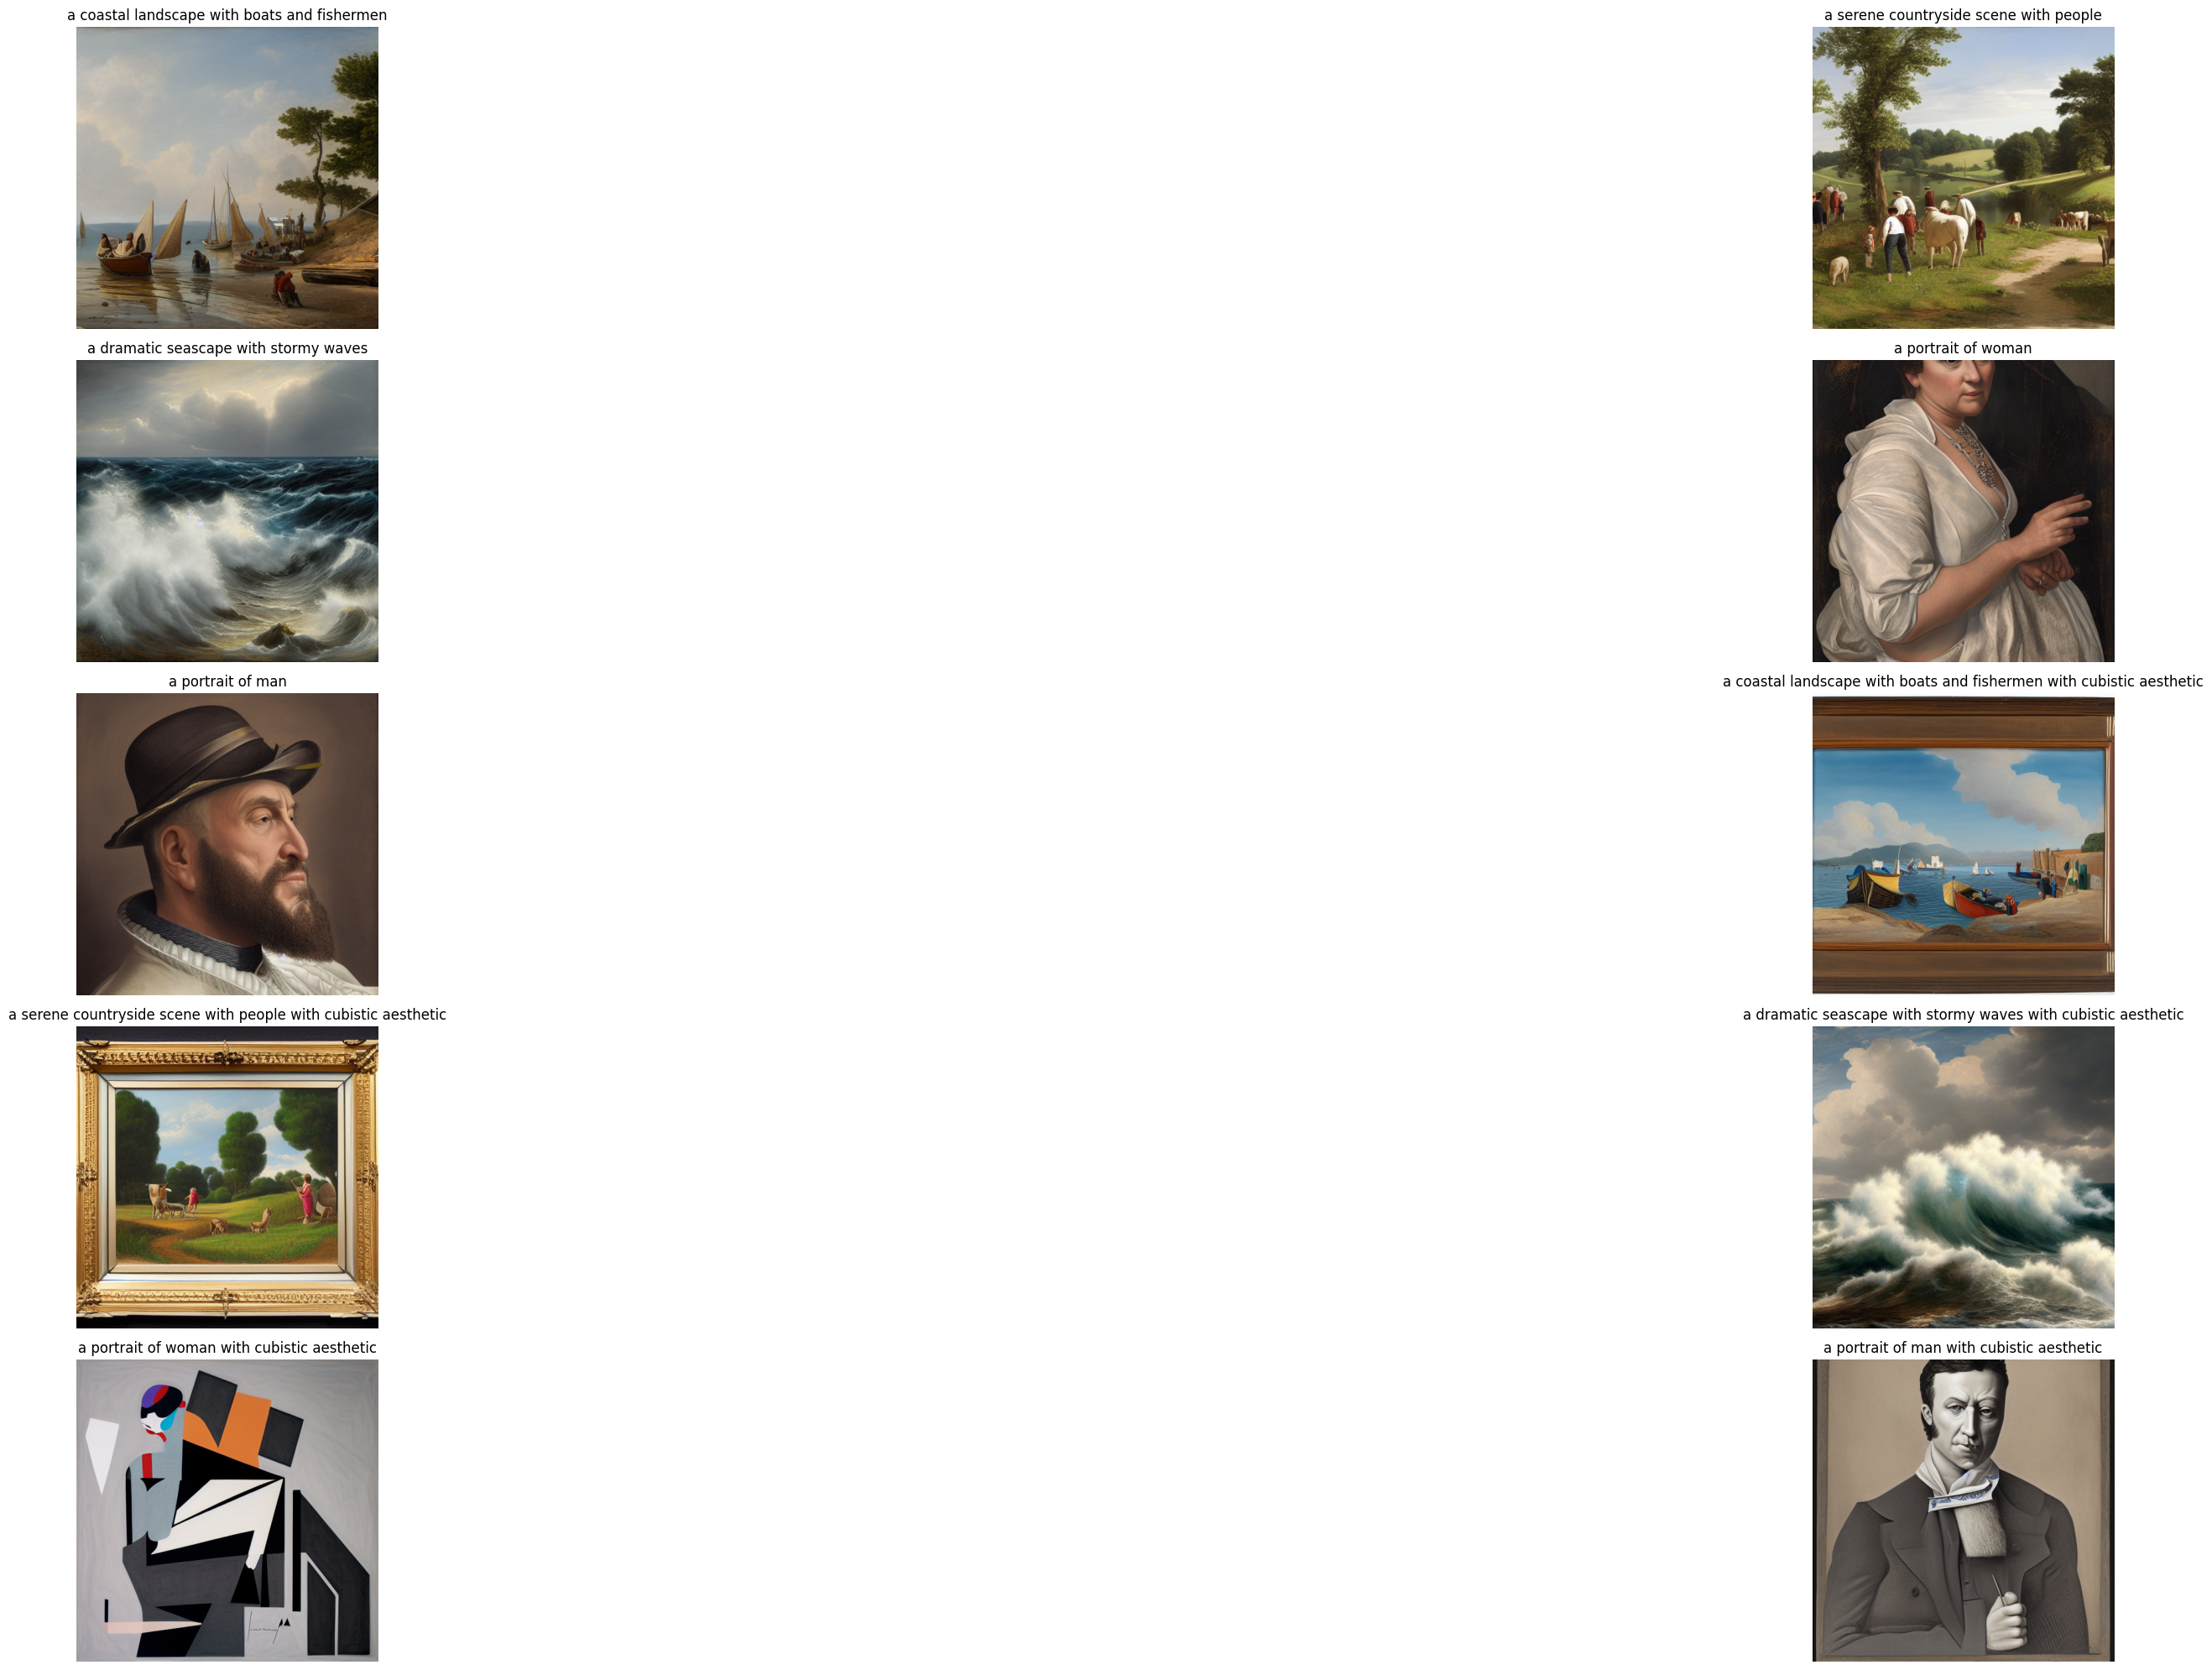

In [ ]:
display_grid(sdx_images, rows=5, cols=len(prompts) // 5, figsize=(60, 20), titles=prompts)

os.makedirs("./generated_lora", exist_ok=True)
for i, img in enumerate(sdx_images):
    img.save(f"./generated_lora/sdx_img_lora_{i}.png")

In [ ]:
!zip -r generated_lora.zip generated_lora

from google.colab import files
files.download('generated_lora.zip')

  adding: generated_lora/ (stored 0%)
  adding: generated_lora/sdx_img_lora_10.png (deflated 0%)
  adding: generated_lora/sdx_img_lora_11.png (deflated 0%)
  adding: generated_lora/sdx_img_lora_4.png (deflated 0%)
  adding: generated_lora/sdx_img_lora_7.png (deflated 0%)
  adding: generated_lora/sdx_img_lora_6.png (deflated 0%)
  adding: generated_lora/sdx_img_lora_2.png (deflated 0%)
  adding: generated_lora/sdx_img_lora_0.png (deflated 0%)
  adding: generated_lora/sdx_img_lora_9.png (deflated 0%)
  adding: generated_lora/sdx_img_lora_3.png (deflated 0%)
  adding: generated_lora/sdx_img_lora_8.png (deflated 0%)
  adding: generated_lora/sdx_img_lora_1.png (deflated 0%)
  adding: generated_lora/sdx_img_lora_5.png (deflated 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
del sdx_pipe
cleanup_memory()